In [2]:
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

from hyperopt import hp, fmin, tpe, Trials

import io
import os
from PIL import Image

import json

In [3]:
df = pd.read_csv('../../data/day_ahead_energy_prices.csv', delimiter=",")[::-1]
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.rename(columns={"hourly day-ahead energy price": "Price"}, inplace=True)
df

,Price
Datetime,
2024-11-21 23:00:00,107.46
2024-11-21 22:00:00,122.90
2024-11-21 21:00:00,123.05
2024-11-21 20:00:00,131.33
2024-11-21 19:00:00,154.05
...,...
2018-10-01 04:00:00,47.59
2018-10-01 03:00:00,47.38
2018-10-01 02:00:00,51.41


In [4]:
mix_df = pd.read_csv('../../data/hourly_market_mix_cleaned.csv', delimiter=",")[::-1]
mix_df.set_index("Timestamp", inplace=True)
mix_df.index = pd.to_datetime(mix_df.index)
mix_df.rename_axis("Datetime", inplace=True) 
mix_df = mix_df.loc[:, mix_df.max() >= 0.01]
mix_df


,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore
Datetime,,,,,,,,,,,
2024-10-30 00:00:00,0.101101,0.145455,0.045090,0.260219,0.243971,0.000000,0.049146,0.000022,0.0,0.047519,0.107476
2024-10-29 23:00:00,0.097725,0.149445,0.044872,0.274110,0.243789,0.000000,0.046156,0.000599,0.0,0.040935,0.102369
2024-10-29 22:00:00,0.095872,0.150584,0.047273,0.270704,0.255679,0.000000,0.046154,0.001140,0.0,0.035149,0.097447
2024-10-29 21:00:00,0.095560,0.150384,0.044436,0.265195,0.268427,0.000000,0.046835,0.002805,0.0,0.030024,0.096333
2024-10-29 20:00:00,0.093081,0.142999,0.047220,0.253702,0.278486,0.000000,0.044794,0.014459,0.0,0.027928,0.097331
...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 04:00:00,0.092527,0.148990,0.019701,0.282126,0.146368,0.138012,0.040888,0.003391,0.0,0.045451,0.082545
2018-10-01 03:00:00,0.093932,0.146157,0.020071,0.286085,0.153114,0.140053,0.041441,0.003452,0.0,0.039751,0.075943
2018-10-01 02:00:00,0.094656,0.139489,0.020001,0.286402,0.161350,0.142441,0.041791,0.003471,0.0,0.038929,0.071471


In [5]:
# weather_forecast_df = pd.read_csv("../../data/weather_forcast_prediciton.csv")[::-1]
# weather_forecast_df.set_index("date" ,inplace=True)
# weather_forecast_df.index = pd.to_datetime(weather_forecast_df.index)
# weather_forecast_df.index = weather_forecast_df.index.tz_localize(None)
# weather_forecast_df.rename_axis("Datetime",inplace=True)
# weather_forecast_df.index = weather_forecast_df.index - pd.Timedelta(hours=24)

# weather_forecast_df

daily_weather_df = pd.read_csv('../../data/daily_weather.csv', delimiter=",")

daily_weather_df.set_index('date', inplace=True)
daily_weather_df.index = pd.to_datetime(daily_weather_df.index)

daily_weather_df.index = daily_weather_df.index.tz_localize(None)

daily_weather_df.rename(columns={
    'Precipitation (rain/snow)': 'precipitation',
    'wind_speed_100m': 'wind_speed_80m',
    'Global Horizontal Irradiance': 'shortwave_radiation',
    'direct_radiation': 'direct_radiation', 
}, inplace=True)

In [6]:
merged_df = pd.concat([df, mix_df, daily_weather_df], axis=1, join='inner')
# merged_df = pd.concat([df, mix_df, weather_forecast_d ], axis=1, join='inner')
merged_df

,Price,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,...,Wind onshore,temperature_2m,relative_humidity_2m,precipitation,surface_pressure,cloud_cover,wind_speed_80m,sunshine_duration,shortwave_radiation,direct_radiation
2024-10-30 00:00:00,100.71,0.101101,0.145455,0.045090,0.260219,0.243971,0.000000,0.049146,0.000022,0.0,...,0.107476,11.857000,92.975290,0.1,988.53284,100.0,17.640919,0.0,0.0,0.0
2024-10-29 23:00:00,103.09,0.097725,0.149445,0.044872,0.274110,0.243789,0.000000,0.046156,0.000599,0.0,...,0.102369,11.857000,92.051910,0.3,988.24380,100.0,17.519281,0.0,0.0,0.0
2024-10-29 22:00:00,118.08,0.095872,0.150584,0.047273,0.270704,0.255679,0.000000,0.046154,0.001140,0.0,...,0.097447,11.857000,91.440810,0.0,988.34015,100.0,16.167967,0.0,0.0,0.0
2024-10-29 21:00:00,124.05,0.095560,0.150384,0.044436,0.265195,0.268427,0.000000,0.046835,0.002805,0.0,...,0.096333,11.957001,90.537970,0.1,988.35297,100.0,18.557467,0.0,0.0,0.0
2024-10-29 20:00:00,140.60,0.093081,0.142999,0.047220,0.253702,0.278486,0.000000,0.044794,0.014459,0.0,...,0.097331,12.057000,89.644394,0.1,988.17300,100.0,18.179998,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 04:00:00,47.59,0.092527,0.148990,0.019701,0.282126,0.146368,0.138012,0.040888,0.003391,0.0,...,0.082545,4.557000,83.822650,0.0,975.15720,89.0,17.447933,0.0,0.0,0.0
2018-10-01 03:00:00,47.38,0.093932,0.146157,0.020071,0.286085,0.153114,0.140053,0.041441,0.003452,0.0,...,0.075943,4.207000,84.381560,0.0,975.30334,57.0,18.359999,0.0,0.0,0.0
2018-10-01 02:00:00,51.41,0.094656,0.139489,0.020001,0.286402,0.161350,0.142441,0.041791,0.003471,0.0,...,0.071471,4.457000,83.512050,0.0,975.52920,4.0,17.551615,0.0,0.0,0.0
2018-10-01 01:00:00,56.10,0.094738,0.142985,0.020278,0.285558,0.157544,0.142376,0.041972,0.003478,0.0,...,0.073151,4.907000,81.800370,0.0,975.68510,3.0,16.434305,0.0,0.0,0.0


In [7]:
TEST_SIZE = 0.18

SPLIT_DATE_EVAL = merged_df.index[int(TEST_SIZE * len(merged_df))]


train = merged_df.loc[merged_df.index < SPLIT_DATE_EVAL]
initial_test = merged_df.loc[merged_df.index >= SPLIT_DATE_EVAL]


test_eval_split = int(len(initial_test) / 2)

SPLIT_DATE_TEST = merged_df.index[int(TEST_SIZE * len(merged_df)) - test_eval_split - 1]

test = initial_test.iloc[:test_eval_split]
eval = initial_test.iloc[test_eval_split:]

eval

,Price,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,...,Wind onshore,temperature_2m,relative_humidity_2m,precipitation,surface_pressure,cloud_cover,wind_speed_80m,sunshine_duration,shortwave_radiation,direct_radiation
2024-04-12 17:00:00,57.37,0.084674,0.017899,0.044440,0.077898,0.132564,0.0,0.036925,0.007586,0.277852,...,0.253722,16.057001,73.436180,0.0,992.14680,100.0,21.599998,0.0000,86.0,5.0
2024-04-12 16:00:00,0.22,0.071990,0.014774,0.039949,0.054478,0.106525,0.0,0.030741,0.000887,0.365533,...,0.243041,16.657000,69.062580,0.0,992.41406,100.0,25.346148,0.0000,145.0,7.0
2024-04-12 15:00:00,0.18,0.064289,0.014542,0.035330,0.048058,0.094356,0.0,0.027463,0.000512,0.418821,...,0.226909,17.407000,63.070004,0.0,992.69970,100.0,24.546085,3306.4563,278.0,91.0
2024-04-12 14:00:00,0.01,0.059697,0.017247,0.033430,0.046278,0.088183,0.0,0.025579,0.000441,0.449089,...,0.210756,17.507000,62.256092,0.0,993.19446,100.0,24.648829,3600.0000,355.0,115.0
2024-04-12 13:00:00,-0.07,0.059205,0.017442,0.031908,0.050033,0.087802,0.0,0.025841,0.000090,0.454611,...,0.200917,17.207000,63.872242,0.0,993.73580,100.0,24.522316,3600.0000,417.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25 13:00:00,76.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.907000,48.997066,0.0,988.54300,96.0,9.983106,3600.0000,546.0,415.0
2023-09-25 12:00:00,76.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.507000,49.727820,0.0,988.97670,97.0,10.948973,3600.0000,615.0,531.0
2023-09-25 11:00:00,89.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17.757000,54.110250,0.0,988.98130,37.0,10.685391,3600.0000,602.0,511.0
2023-09-25 10:00:00,93.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,16.657000,62.060150,0.0,989.23180,97.0,9.585739,3600.0000,545.0,457.0


In [8]:
merged_df["Price"].describe()


count    53161.000000
mean        93.402616
std         97.838578
min       -500.000000
25%         36.490000
50%         62.430000
75%        110.710000
max        871.000000
Name: Price, dtype: float64

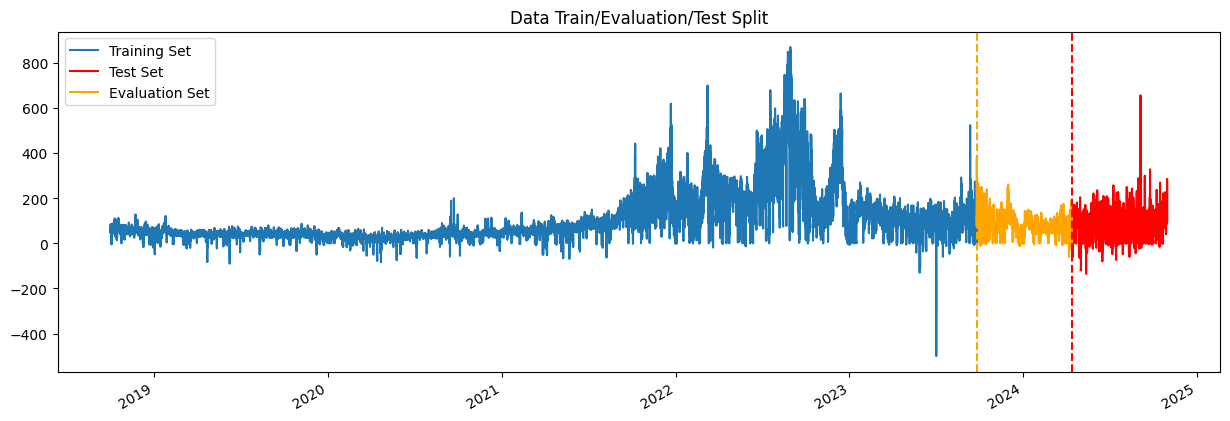

,Price,Nuclear
2023-09-25 08:00:00,143.00,NaN
2023-09-25 07:00:00,139.15,NaN
2023-09-25 06:00:00,109.36,NaN
2023-09-25 05:00:00,50.15,NaN
2023-09-25 04:00:00,0.49,NaN
...,...,...
2018-10-01 04:00:00,47.59,0.138012
2018-10-01 03:00:00,47.38,0.140053
2018-10-01 02:00:00,51.41,0.142441
2018-10-01 01:00:00,56.10,0.142376


In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
train["Price"].plot(ax=ax, label='Training Set', title='Data Train/Evaluation/Test Split')
test["Price"].plot(ax=ax, label='Test Set', color="red")
eval["Price"].plot(ax=ax, label='Evaluation Set', color="orange")
ax.axvline(SPLIT_DATE_EVAL, color='orange', ls='--')
ax.axvline(SPLIT_DATE_TEST, color='red', ls='--')
ax.legend(['Training Set', 'Test Set', 'Evaluation Set'])
plt.show()

In [ ]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    for window in [3, 6, 12]: # hours
        df[f'ma_{int(window)}_hours'] = df['Price'].rolling(window=window).mean()
        df[f'biomass_ma_{int(window)}_hours'] = df['Biomass'].rolling(window=window).mean()
        df[f'pumped_storage_generation_ma_{int(window)}_hours'] = df['Pumped storage generation'].rolling(window=window).mean()
        df[f'hard_coal_ma_{int(window)}_hours'] = df['Hard Coal'].rolling(window=window).mean()
    
    for window in [24, 72, 168]:  # 1 day 3 days, and 1 week
        df[f'ma_{int(window / 24)}_days'] = df['Price'].rolling(window=window).mean()
        df[f'biomass_ma_{int(window / 24)}_days'] = df['Biomass'].rolling(window=window).mean()
        df[f'pumped_storage_generation_ma_{int(window / 24)}_days'] = df['Pumped storage generation'].rolling(window=window).mean()
        df[f'hard_coal_ma_{int(window / 24)}_days'] = df['Hard Coal'].rolling(window=window).mean()

    return df

### Feature Selection

In [ ]:
train = create_features(train)
test = create_features(test)
eval = create_features(eval)

FEATURES = [
    "hour",
    "dayofyear",
    "dayofweek",
    "ma_3_hours",
    "ma_6_hours",
    "ma_1_days",
    "ma_3_days",
    "ma_7_days",
    "Biomass",
    "biomass_ma_3_hours",
    "biomass_ma_6_hours",
    "biomass_ma_1_days",
    "biomass_ma_3_days",
    "biomass_ma_7_days",
    "pumped_storage_generation_ma_3_hours",
    "pumped_storage_generation_ma_6_hours",
    "pumped_storage_generation_ma_1_days",
    "pumped_storage_generation_ma_3_days",
    "pumped_storage_generation_ma_7_days",
    "Hard Coal",
    "hard_coal_ma_3_hours",
    "hard_coal_ma_6_hours",
    "hard_coal_ma_1_days",
    "hard_coal_ma_3_days",
    "hard_coal_ma_7_days",
    "Hydro",
    "Lignite",
    "Natural Gas",
    "Nuclear",
    "Other",
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "Wind onshore",
    # "temperature_2m",
    # "temperature_2m_previous_day1",
    # "temperature_2m_previous_day2",
    # "temperature_2m_previous_day3",
    # "temperature_2m_previous_day4",
    # "temperature_2m_previous_day5",
    # "temperature_2m_previous_day6",
    # "temperature_2m_previous_day7",
    # "relative_humidity_2m",
    # "relative_humidity_2m_previous_day1",
    # "relative_humidity_2m_previous_day2",
    # "relative_humidity_2m_previous_day3",
    # "relative_humidity_2m_previous_day4",
    # "relative_humidity_2m_previous_day5",
    # "relative_humidity_2m_previous_day6",
    # "relative_humidity_2m_previous_day7",
    # "precipitation",
    # "precipitation_previous_day1",
    # "precipitation_previous_day2",
    # "precipitation_previous_day3",
    # "precipitation_previous_day4",
    # "precipitation_previous_day5",
    # "precipitation_previous_day6",
    # "precipitation_previous_day7",
    # "surface_pressure",
    # "surface_pressure_previous_day1",
    # "surface_pressure_previous_day2",
    # "surface_pressure_previous_day3",
    # "surface_pressure_previous_day4",
    # "surface_pressure_previous_day5",
    # "surface_pressure_previous_day7",
    # "shortwave_radiation",
    # "shortwave_radiation_previous_day1",
    # "shortwave_radiation_previous_day2",
    # "shortwave_radiation_previous_day3",
    # "shortwave_radiation_previous_day4",
    # "shortwave_radiation_previous_day5",
    # "shortwave_radiation_previous_day6",
    # "shortwave_radiation_previous_day7",
    # "wind_speed_80m",
    # "wind_speed_80m_previous_day1",
    # "wind_speed_80m_previous_day2",
    # "wind_speed_80m_previous_day3",
    # "wind_speed_80m_previous_day4",
    # "wind_speed_80m_previous_day5",
    # "wind_speed_80m_previous_day6",
    # "wind_speed_80m_previous_day7",

 #  -- Actual Weather -- 
    "temperature_2m",
    "relative_humidity_2m",
    "precipitation",
    "surface_pressure",
    "cloud_cover",
    "wind_speed_80m",
    "sunshine_duration",
    "shortwave_radiation",
    "direct_radiation",
]

TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

### Auto ML

In [ ]:
def objective(params):

    # params['max_depth'] = int(params['max_depth'])
    # params['n_estimators'] = int(params['n_estimators'])
    # params['min_child_weight'] = int(params['min_child_weight'])
    # params['max_delta_step'] = int(params['max_delta_step'])
    # params['early_stopping_rounds'] = int(params['early_stopping_rounds'])

    # best_params = {
    # "base_score": np.float64(0.3888133835396405),
    # "colsample_bytree": np.float64(0.6349243426308729),
    # "early_stopping_rounds": np.int64(40),
    # "gamma": np.float64(0.8154683526419992),
    # "learning_rate": np.float64(0.06),
    # "max_depth": np.int64(200),
    # "min_child_weight": np.int64(7),
    # "n_estimators": np.int64(150),
    # "subsample": np.float64(0.5719023844219375),
    # }

    model = xgb.XGBRegressor(
        base_score=params['base_score'],
        early_stopping_rounds= np.int64(40),
        max_depth= np.int64(200),
        learning_rate=params['learning_rate'],
        n_estimators=np.int64(150),
        gamma=np.float64(0.8154683526419992),
        # min_child_weight=params['min_child_weight'],
        # subsample=params['subsample'],
        # colsample_bytree=params['colsample_bytree'],
        # colsample_bynode=params['colsample_bynode'],
        # colsample_bylevel=params['colsample_bylevel'],
        # max_delta_step=params['max_delta_step'],
        # reg_lambda=params['reg_lambda'],
        eval_metric='rmse',
        objective='reg:squarederror',
    )
    
    # Fit the model on the training data
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],  # Provide validation set for early stopping
        verbose=False  # Suppress training output
    )
    
    # Predict on the validation set
    predictions = model.predict(X_test)
    
    # Calculate the root mean squared error (RMSE)
    rmse = root_mean_squared_error(y_test, predictions)
    
    return rmse

In [ ]:
search = False

search_space = {
    "base_score": hp.uniform("base_score", 0, 1),
    # "early_stopping_rounds": hp.choice("early_stopping_rounds", np.arange(3, 300, 1, dtype=int)),
    # "max_depth": hp.choice("max_depth", np.arange(30, 300, 1, dtype=int)),
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.5),
    # "gamma": hp.uniform("gamma", 0, 1),
    # "reg_lambda": hp.uniform("reg_lambda", 0.7, 0.9),
    # "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    # "colsample_bynode": hp.uniform("colsample_bynode", 0.5, 1),
    # "colsample_bylevel": hp.uniform("colsample_bylevel", 0.5, 1),
    # "n_estimators": hp.choice("n_estimators", np.arange(100, 1000, 10, dtype="int")),
    # "min_child_weight": hp.choice("min_child_weight", np.arange(1, 10, 1, dtype="int")),
    # "max_delta_step": hp.choice("max_delta_step", np.arange(1, 10, 1, dtype="int")),
    # "subsample": hp.uniform("subsample", 0.5, 1),
}

# Keeping track of the optimization history
trials = Trials()

if search:

    # Run the Hyperopt optimization
    best = fmin(
        fn=objective,  # Objective function
        space=search_space,  # Hyperparameter space
        algo=tpe.suggest,  # Optimization algorithm
        max_evals=50,  # Number of trials
        trials=trials,  # Store trials history
    )

In [ ]:
 #Display best parameters
print(f"base_score: {best["base_score"]}, default: 10")
# print(f"early_stopping_rounds: {best["early_stopping_rounds"]}, default: 10")
# print(f"max_depth: {best["max_depth"]}, default: 6")
print(f"learning_rate: {best["learning_rate"]}, default: 0.3")
# print(f"n_estimators: {best["n_estimators"]}, default: 100")
# print(f"gamma: {best["gamma"]}, default: 0")
# print(f"min_child_weight: {best["min_child_weight"]}, default: 1")
# print(f"subsample: {best["subsample"]}, default: 1")
# print(f"colsample_bytree: {best["colsample_bytree"]}, default: 1")
# print(f"colsample_bynode: {best["colsample_bynode"]}, default: 1")
# print(f"colsample_bylevel: {best["colsample_bylevel"]}, default: 1")
# print(f"max_delta_step: {best["max_delta_step"]}, default: 0")
# print(f"reg_lambda: {best["reg_lambda"]}, default: 1")

base_score: 0.9241587012988924, default: 10
learning_rate: 0.03930164794086307, default: 0.3


In [ ]:
if search:
        # Train the final model with the best hyperparameters on the full dataset
    final_model = xgb.XGBRegressor(
            early_stopping_rounds=best['early_stopping_rounds'],
            max_depth=best['max_depth'],
        #     learning_rate=best['learning_rate'],
            n_estimators=best['n_estimators'],
            gamma=best['gamma'],
        #     min_child_weight=best['min_child_weight'],
        #     subsample=best['subsample'],
        #     colsample_bytree=best['colsample_bytree'],
        #     colsample_bynode=best['colsample_bynode'],
        #     colsample_bylevel=best['colsample_bylevel'],
        #     max_delta_step=best['max_delta_step'],
        #     reg_lambda=best['reg_lambda'],
            # reg_alpha=best['reg_alpha'],
            eval_metric='rmse',
            objective='reg:squarederror',
    )

    final_model.fit(X_train, y_train,  eval_set=[(X_val, y_val)])

    # Predict on the test set or validation set
    final_predictions = final_model.predict(X_test)
    final_rmse = root_mean_squared_error(y_test, final_predictions)
    print("\n--- Final model RMSE:", final_rmse, "---")

## Final Model

In [ ]:
update = False

best_params = {
    "base_score": np.float64(0.3888133835396405),
    "colsample_bytree": np.float64(0.6349243426308729),
    "early_stopping_rounds": np.int64(40),
    "gamma": np.float64(0.8154683526419992),
    "learning_rate": np.float64(0.06),
    "max_depth": np.int64(200),
    "min_child_weight": np.int64(7),
    "n_estimators": np.int64(150),
    "subsample": np.float64(0.5719023844219375),
}

if update:
    best_params = {
        "early_stopping_rounds": best['early_stopping_rounds'],
        "max_depth": best['max_depth'],
        "learning_rate": best['learning_rate'],
        "n_estimators": best['n_estimators'],
        "gamma": best['gamma'],
        "min_child_weight": best['min_child_weight'],
        "subsample": best['subsample'],
        "colsample_bytree": best['colsample_bytree'],
        "colsample_bynode": best['colsample_bynode'],
        "colsample_bylevel": best['colsample_bylevel'],
        "max_delta_step": best['max_delta_step'],
        "reg_lambda": best['reg_lambda'],
    }

# print(dict(best_params))

reg = xgb.XGBRegressor(**best_params)

reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=25)

[0]	validation_0-rmse:79.83371
[25]	validation_0-rmse:20.80706
[50]	validation_0-rmse:11.03126
[75]	validation_0-rmse:9.78763
[100]	validation_0-rmse:9.60130
[125]	validation_0-rmse:9.55988
[149]	validation_0-rmse:9.55826


XGBRegressor(base_score=np.float64(0.3888133835396405), booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.6349243426308729), device=None,
             early_stopping_rounds=np.int64(40), enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.8154683526419992), grow_policy=None,
             importance_t...interaction_constraints=None,
             learning_rate=np.float64(0.06), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=np.int64(200), max_leaves=None,
             min_child_weight=np.int64(7), missing=nan,
             monotone_constraints=None, multi_strategy=None,
             n_estimators=np.int64(150), n_jobs=None, num_parallel_tree=None,
             random_state=None, ...)

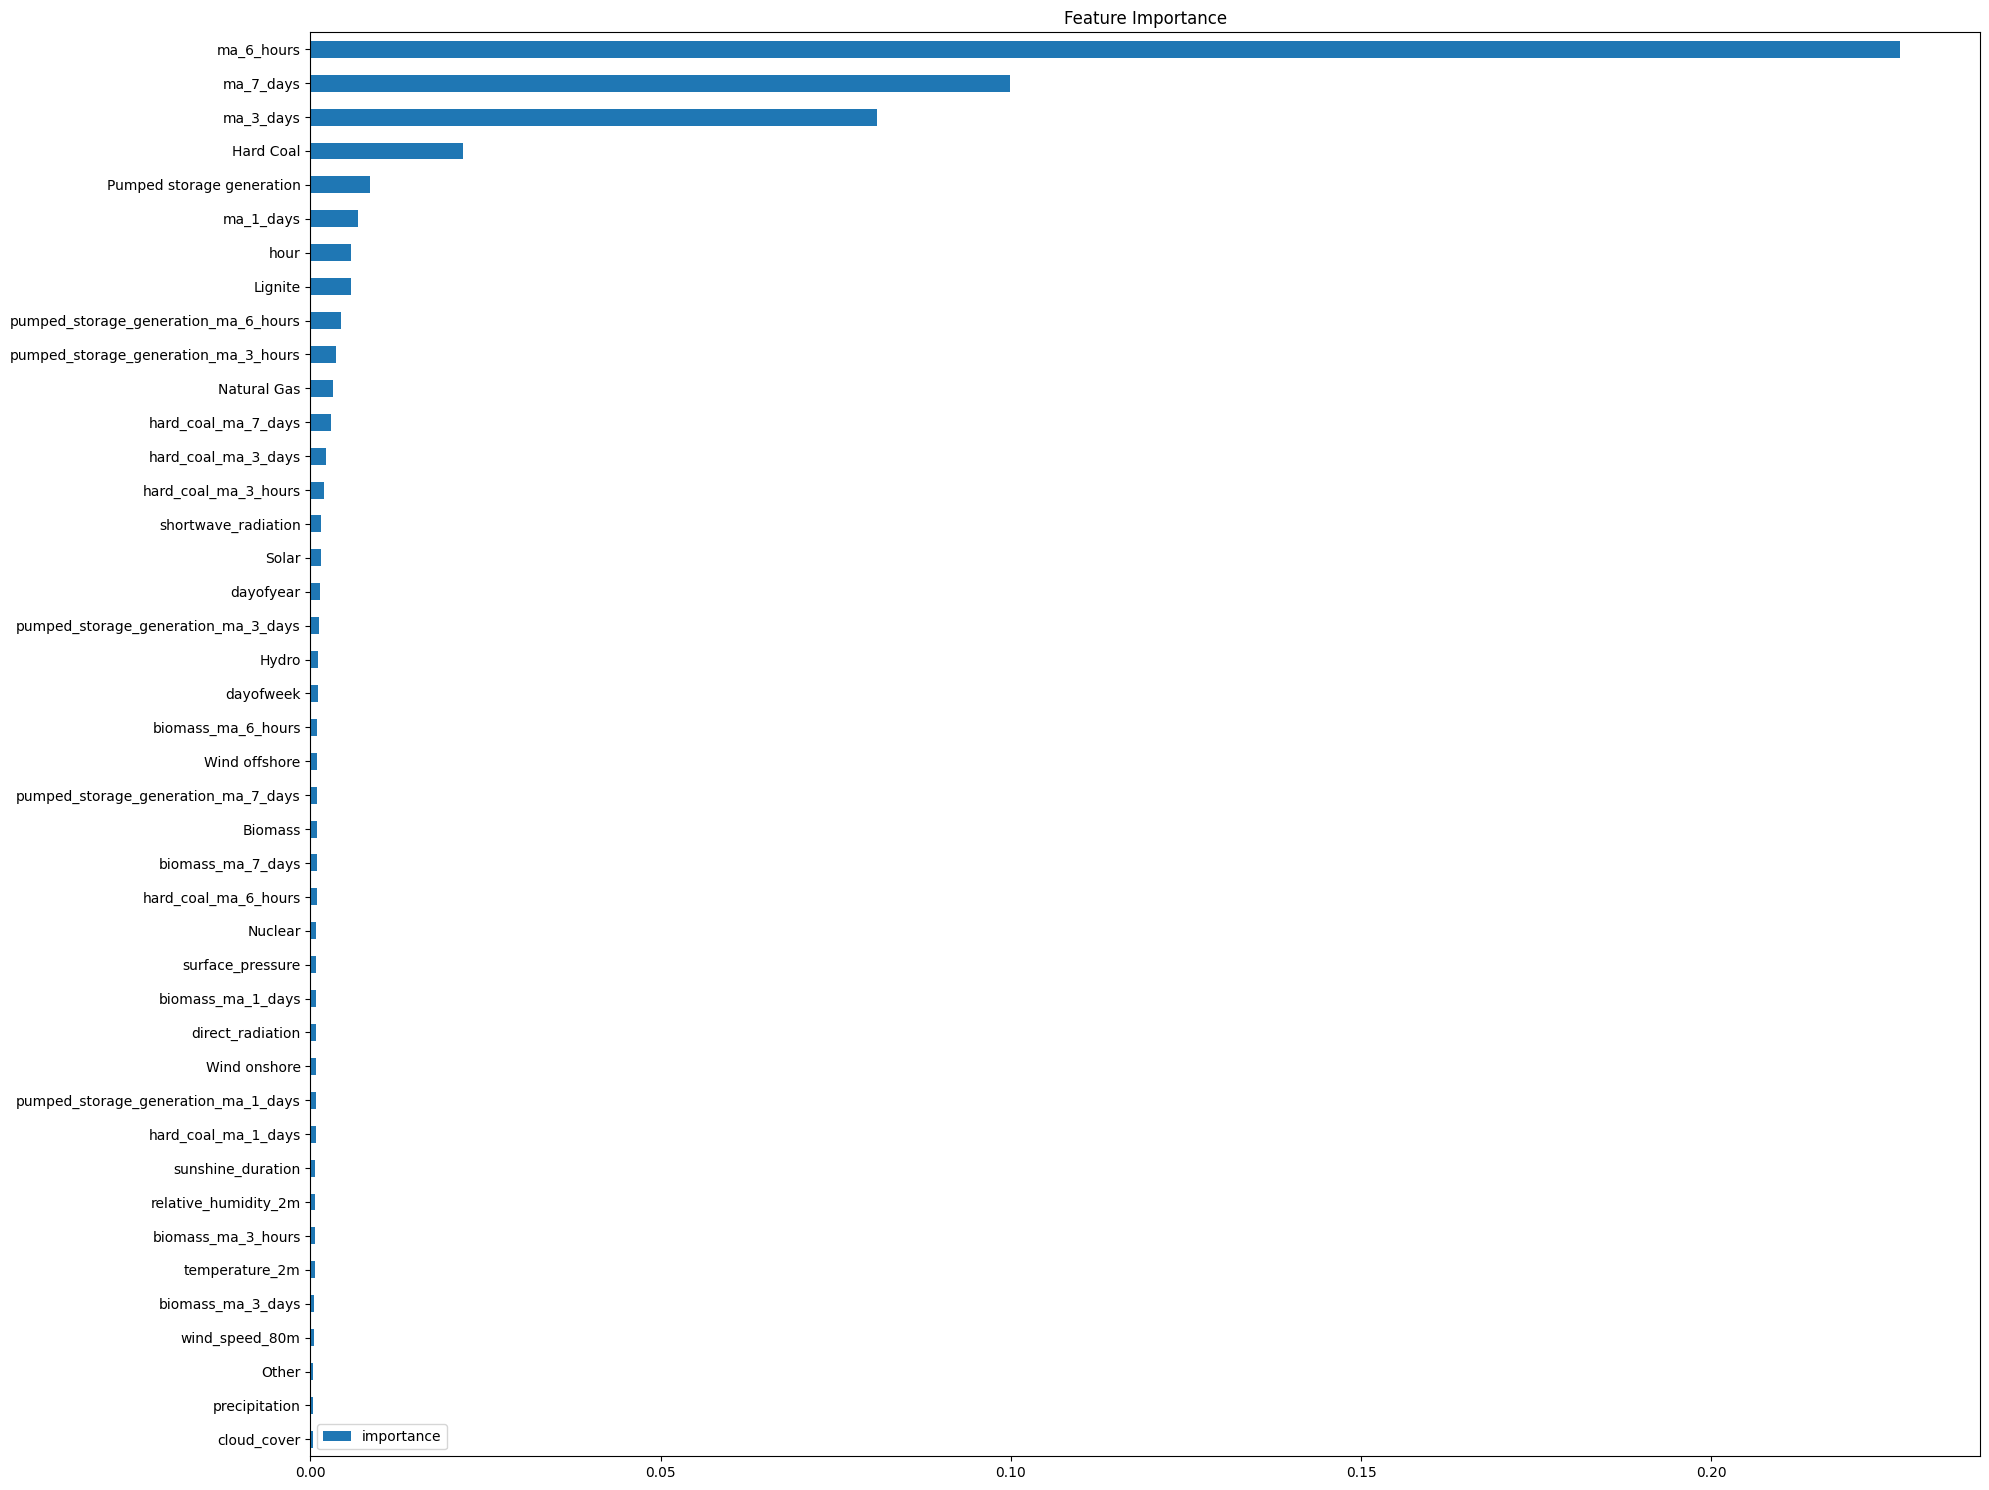

In [ ]:
# plt.figure(figsize=(30, 20))

idx_limited = np.argsort(reg.feature_importances_)[::-1][1:]
fi_sorted_limited = reg.feature_importances_[idx_limited]
fn_sorted_limited = reg.feature_names_in_[idx_limited]

fi = pd.DataFrame(data=fi_sorted_limited,
             index=fn_sorted_limited,
             columns=['importance'], )
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(20, 15))
plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, format='png')
plt.show()
plt.close()
buf.seek(0)

feature_importance_image = Image.open(buf)

In [ ]:
test['prediction'] = reg.predict(X_test)
prediction_df = merged_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [ ]:
#test error fot the entire test set
score = root_mean_squared_error(test[TARGET], test['prediction'])
print(f'RMSE Score on Test set: {score:.2f}')

RMSE Score on Test set: 13.09


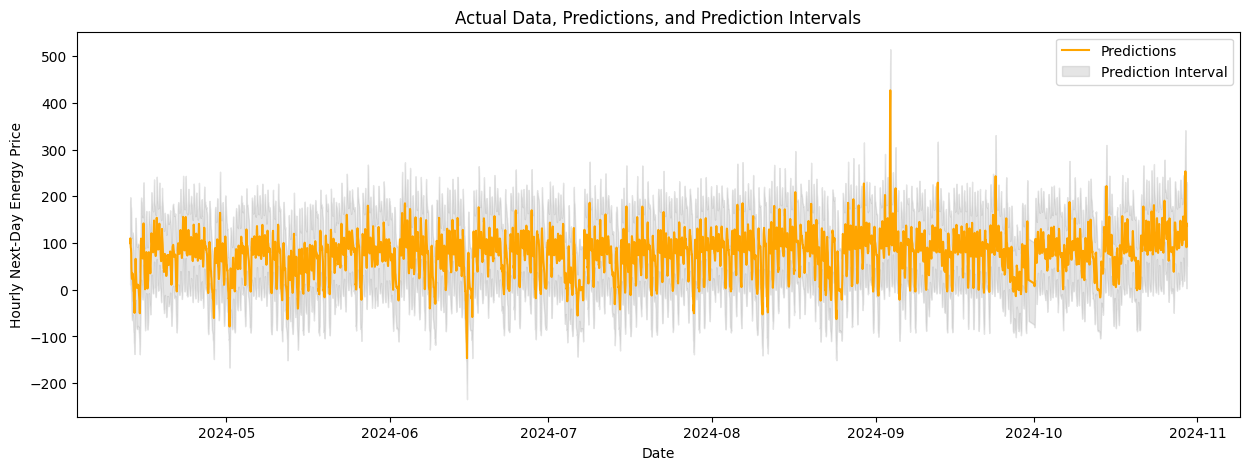

In [ ]:
import matplotlib.dates as mdates


# Calculate prediction intervals
prediction_df['lower_bound'] = prediction_df['prediction'] - 1.96 * prediction_df['prediction'].std()
prediction_df['upper_bound'] = prediction_df['prediction'] + 1.96 * prediction_df['prediction'].std()

# Plot the actual data, predictions, and prediction intervals
fig, ax = plt.subplots(figsize=(15, 5))

# Plot actual data
# ax.plot(prediction_df.index, prediction_df[TARGET], label='Actual Data', color='blue')

# Plot predictions
ax.plot(prediction_df.index, prediction_df['prediction'], label='Predictions', color='orange')

# Plot prediction intervals
ax.fill_between(prediction_df.index, prediction_df['lower_bound'], prediction_df['upper_bound'], color='gray', alpha=0.2, label='Prediction Interval')

# Formatting the plot
ax.set_title('Actual Data, Predictions, and Prediction Intervals')
ax.set_xlabel('Date')
ax.set_ylabel('Hourly Next-Day Energy Price')
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()

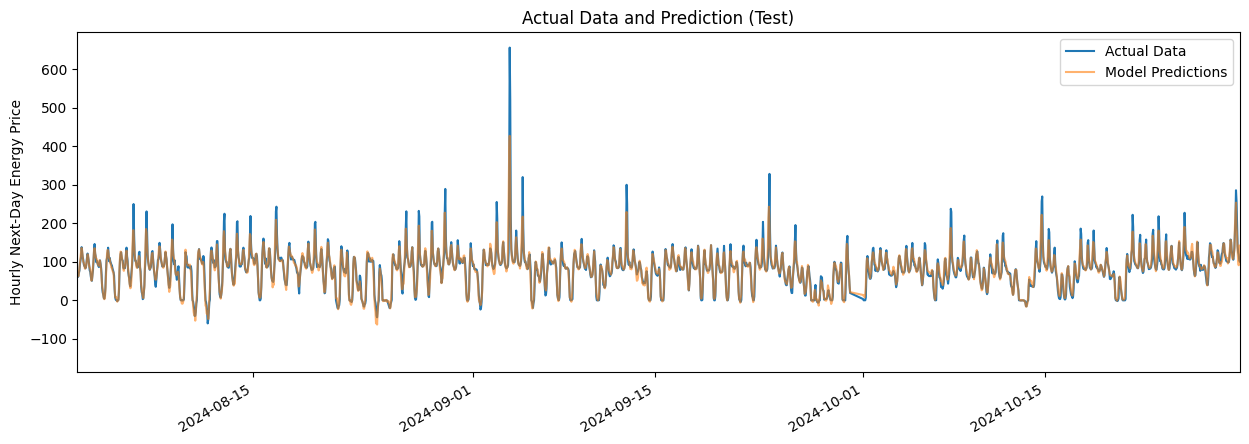

In [ ]:

WINDOW = prediction_df.iloc[:int(0.04 * (len(prediction_df)))].copy()

ax = WINDOW[[TARGET]].plot(figsize=(15, 5))
prediction_df['prediction'].plot(ax=ax, style='-', alpha=0.6)
ax.set_xlim(WINDOW.index.min(), WINDOW.index.max())
ax.set_ylabel("Hourly Next-Day Energy Price")
plt.legend(['Actual Data', 'Model Predictions'])    
ax.set_title('Actual Data and Prediction (Test)')

buf = io.BytesIO()
plt.savefig(buf, format='png')
plt.show()
plt.close()
buf.seek(0)

ts_image = Image.open(buf)

### Average absolute error by day

In [ ]:
test['error'] = np.abs(test[TARGET] - prediction_df['prediction'])
test['date'] = test.index.date
test['error'].groupby(test['date']).mean()

date
2024-04-12    13.897264
2024-04-13     7.967558
2024-04-14     8.024724
2024-04-15     9.020552
2024-04-16     5.966229
                ...    
2024-10-26     7.765011
2024-10-27     7.383884
2024-10-28     5.540169
2024-10-29    14.323543
2024-10-30    37.280646
Name: error, Length: 202, dtype: float64

### Specific Date Predictions

In [11]:
date = '2024-10-29'
predictions = prediction_df.loc[date, 'prediction']

# Display the result
print(predictions)

NameError: name 'prediction_df' is not defined

In [ ]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f'./pickle/model_{score: .4g}_rmse_{ts}'
os.makedirs(output_dir, exist_ok=True)

model_dump_path = os.path.join(output_dir, "model.pickle")
with open(model_dump_path, "wb") as file:
    pickle.dump(reg, file)
hp_path = os.path.join(output_dir, "hyperparams.json")
with open(hp_path, "w") as file:
    best_params_native = {k: (int(v) if isinstance(v, (np.integer, int)) else float(v) if isinstance(v, (np.floating, float)) else v) for k, v in best_params.items()}
    json.dump(best_params_native, file, indent=4)
output_filename = 'plot_image.png'
ts_chart_path = os.path.join(output_dir, output_filename)
ts_image.save(ts_chart_path)

output_filename = 'feature_importance.png'
fi_path = os.path.join(output_dir, output_filename)
feature_importance_image.save(fi_path)

save models pickel
add 500 to axis -> z-standardisation might also work
features?
register

